# Projeto PCD: Simulação e Análise de Modelos de Difusão de Contaminantes em Água

**Integrante(s)**:
              Rennam Victor Cabral de Faria - 164933 -  BCT


### (Relatório 2)



## Código de modelo de difusão usando **CUDA**

Versao do Cuda tollkit usada no coddigo rodando localmente na maquina: 5.0 Versao da GPU = gtx750


In [ ]:
!nvidia-smi

Thu Jan  2 21:53:06 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

----

In [ ]:
!pip install git+https://github.com/lesc-ufv/cad4u.git &> /dev/null
!git clone https://github.com/lesc-ufv/cad4u &> /dev/null
%load_ext plugin

In [ ]:
# Cria o arquivo que salvar a matriz
open('/content/matriz_Cuda_output.txt', 'w').close()

In [ ]:
%%gpu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include <cuda_runtime.h>
#include <cuda.h>

#define N 2000  // Tamanho da grade
#define T 1000  // Quantidade de iterações
#define D 0.1   // Coeficiente de coesão
#define DELTA_T 0.01
#define DELTA_X 1.0

#define RADIUS 1
#define BLOCK_SIZE 16

#define cudaCheck(error) \
  if (error != cudaSuccess) { \
    printf("Fatal error: %s at %s:%d\n", \
        cudaGetErrorString(error), \
        __FILE__, __LINE__); \
    exit(1); \
}

__global__ void diff_eq(const double *input, double *output, int width, int height) {
    // Calculate thread indices - simplified for clarity
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int globalX = blockIdx.x * blockDim.x + tx;
    int globalY = blockIdx.y * blockDim.y + ty;

    // Shared memory for 2D block
    __shared__ double sharedMem[BLOCK_SIZE + 2][BLOCK_SIZE + 2];

    // Local coordinates (including halo)
    int localX = tx + 1;
    int localY = ty + 1;

    // Initialize shared memory
    sharedMem[localY][localX] = 0.0;
    __syncthreads();

    // Load data into shared memory
    if (globalX < width && globalY < height) {
        sharedMem[localY][localX] = input[globalY * width + globalX];
    }

    // Load halo cells
    if (tx == 0 && globalX > 0) {
        sharedMem[localY][0] = input[globalY * width + (globalX - 1)];
    }
    if (tx == blockDim.x - 1 && globalX < width - 1) {
        sharedMem[localY][localX + 1] = input[globalY * width + (globalX + 1)];
    }
    if (ty == 0 && globalY > 0) {
        sharedMem[0][localX] = input[(globalY - 1) * width + globalX];
    }
    if (ty == blockDim.y - 1 && globalY < height - 1) {
        sharedMem[localY + 1][localX] = input[(globalY + 1) * width + globalX];
    }

    __syncthreads();

    // Compute stencil only for valid points
    if (globalX > 0 && globalX < width-1 && globalY > 0 && globalY < height-1) {
        double center = sharedMem[localY][localX];
        double north = sharedMem[localY-1][localX];
        double south = sharedMem[localY+1][localX];
        double west = sharedMem[localY][localX-1];
        double east = sharedMem[localY][localX+1];

        double newValue = center + D * (
            north + south + west + east - 4.0 * center
        ) * (DELTA_T / (DELTA_X * DELTA_X));

        output[globalY * width + globalX] = newValue;
    }
}

__global__ void calculate_diffmedio(const double *input, const double *output, float *difmedio, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= 1 && x < width - 1 && y >= 1 && y < height - 1) {
        float diff = fabs(output[y * width + x] - input[y * width + x]);
        atomicAdd(difmedio, diff);
    }
}

int main() {
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Tamanho da matriz N*N (em bytes)
    size_t size = N * N * sizeof(double);

    // =========== Host setup =============

    // Alocar e inicializar a matriz no host
    double *host_C = (double *)malloc(size);
    double *host_C_output = (double *)malloc(size);

    // Verifica se a matriz foi criada corretamente
    if (host_C == NULL || host_C_output == NULL) {
      fprintf(stderr, "Falha na alocação de memória\n");
      return 1;
    }
    // Limpa a matrizes
    for (int i = 0; i < (N * N); i++) {
        host_C[i] = 0;
        host_C_output[i] = 0;
    }

    // Inicializa a concsentração no centro da matriz C
    host_C[((N/2) * N) + N/2] = 1.0;

    // ========== Device setup ============

    // Alocar e inicializar a matriz no device
    double *dev_C, *dev_C_output;

    cudaCheck(cudaMalloc(&dev_C, size));
    cudaCheck(cudaMalloc(&dev_C_output, size));

    // Verifica se a matriz foi criada corretamente
    if (dev_C == NULL || dev_C_output == NULL) {
        fprintf(stderr, "Failed to allocate device memory\n");
        free(host_C);
        free(host_C_output);
        return 1;
    }

    cudaCheck(cudaMemcpy(dev_C, host_C, size, cudaMemcpyHostToDevice));

    // Configura block size e threads
    dim3 blockSize(BLOCK_SIZE, BLOCK_SIZE);
    dim3 gridSize((N + blockSize.x - 1) / blockSize.x,
                  (N + blockSize.y - 1) / blockSize.y);

    // Inicializa o tempo do código
    cudaEventRecord(start);

    // Executa o processo da equação de difusão com as matrizes
    for (int t = 0; t < T; t++) {
        diff_eq<<<gridSize, blockSize>>>(dev_C, dev_C_output, N, N);
        cudaCheck(cudaDeviceSynchronize());

        // Calculate difference mean every 100 iterations
        if ((t % 100) == 0) {
          // Initialize difmedio on host and device
          float host_difmedio;
          float *dev_difmedio;

          cudaMalloc(&dev_difmedio, sizeof(float));
          cudaMemset(dev_difmedio, 0, sizeof(float));

          // Launch kernel to calculate difmedio
          calculate_diffmedio<<<gridSize, blockSize>>>(dev_C, dev_C_output, dev_difmedio, N, N);
          cudaCheck(cudaDeviceSynchronize());

          // Copy difmedio from device to host
          cudaMemcpy(&host_difmedio, dev_difmedio, sizeof(float), cudaMemcpyDeviceToHost);

          // Calculate and print average difmedio
          host_difmedio /= ((N - 2) * (N - 2));
          printf("Iteração %d - diferença média=%g\n", t, host_difmedio);

          // Free device memory
          cudaFree(dev_difmedio);
        }

        // Swap buffers
        double *temp = dev_C;
        dev_C = dev_C_output;
        dev_C_output = temp;
    }

    // Finaliza o tempo do processo da equação e salva-o
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    // Finaliza o tempo do processo da equação
    float elapsed_time = 0;
    cudaEventElapsedTime(&elapsed_time, start, stop);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaError_t error = cudaGetLastError();
    if (error != cudaSuccess) {
        printf("CUDA error: %s\n", cudaGetErrorString(error));
        return -1;
    }
    // Synchronize and check for errors again
    error = cudaDeviceSynchronize();
    if (error != cudaSuccess) {
        printf("CUDA error: %s\n", cudaGetErrorString(error));
        return -1;
    }

    // Retornada dados ao hosst
    cudaCheck(cudaMemcpy(host_C_output, dev_C_output, size, cudaMemcpyDeviceToHost));

    printf("\nConcentração final no centro: %f\n", host_C_output[((N/2) * N) + N/2]);

    // Salvando matrix no aqruivo txt
    FILE *fp = fopen("/content/matriz_Cuda_output.txt", "w");

    if (fp == NULL) {
      printf("Erro ao abrir arquivo.txt\n");
    } else {
      for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
          if (host_C_output[i * N + j] >= 0.0001) {
            fprintf(fp, "i:%d j:%d Matriz:%f ", i, j, host_C_output[i * N + j]);
          }
        }
        fprintf(fp, "\n");
      }
      fclose(fp);
    }

    // Liberar memória alocada
    free(host_C);
    free(host_C_output);
    cudaFree(dev_C);
    cudaFree(dev_C_output);


    // Printa o tempo final
    printf("Tempo final do código (em segundos): %f\n", elapsed_time / 1000.0);

    return 0;
}

ptxas error   : Entry function '_Z7diff_eqPKdPdii' uses too much shared data (0x21020 bytes, 0xc000 max)



### Checando se resultados de Matriz se coincidem com sequencial

In [ ]:
import pandas as pd
import numpy as np
import re

# Le arquivo txt e pega os dados
with open('/content/matriz_Cuda_output.txt', 'r') as file:
    content = file.read()

matches = re.findall(r'i:(\d+) j:(\d+) Matriz:(\d+\.\d+)', content)

if matches:
    # Transforma dados em lista
    data = [[int(i), int(j), f'{float(Matriz):.6e}'] for i, j, Matriz in matches]

    # Cria no formato DataFrame para se inserido na planilha
    df = pd.DataFrame(data, columns=['i', 'j', 'Matriz'])

    df.to_csv('/content/matriz_Cuda_output.csv', index=False)

    print(df.head())

    # Mostrar ressultados
    with open('/content/matriz_Cuda_output.csv', 'r') as f:
        print("Valoress da planilha:")
        print(f.read())
else:
    print("Erro em ler os dados do txt.")

     i     j        Matriz
0  995   998  1.230000e-04
1  995   999  2.850000e-04
2  995  1000  4.080000e-04
3  995  1001  2.850000e-04
4  995  1002  1.230000e-04
Valoress da planilha:
i,j,Matriz
995,998,1.230000e-04
995,999,2.850000e-04
995,1000,4.080000e-04
995,1001,2.850000e-04
995,1002,1.230000e-04
996,997,1.960000e-04
996,998,6.370000e-04
996,999,1.474000e-03
996,1000,2.114000e-03
996,1001,1.474000e-03
996,1002,6.370000e-04
996,1003,1.960000e-04
997,996,1.960000e-04
997,997,8.250000e-04
997,998,2.678000e-03
997,999,6.193000e-03
997,1000,8.880000e-03
997,1001,6.193000e-03
997,1002,2.678000e-03
997,1003,8.250000e-04
997,1004,1.960000e-04
998,995,1.230000e-04
998,996,6.370000e-04
998,997,2.678000e-03
998,998,8.689000e-03
998,999,2.007800e-02
998,1000,2.877600e-02
998,1001,2.007800e-02
998,1002,8.689000e-03
998,1003,2.678000e-03
998,1004,6.370000e-04
998,1005,1.230000e-04
999,995,2.850000e-04
999,996,1.474000e-03
999,997,6.193000e-03
999,998,2.007800e-02
999,999,4.636800e-02
999,1000,6

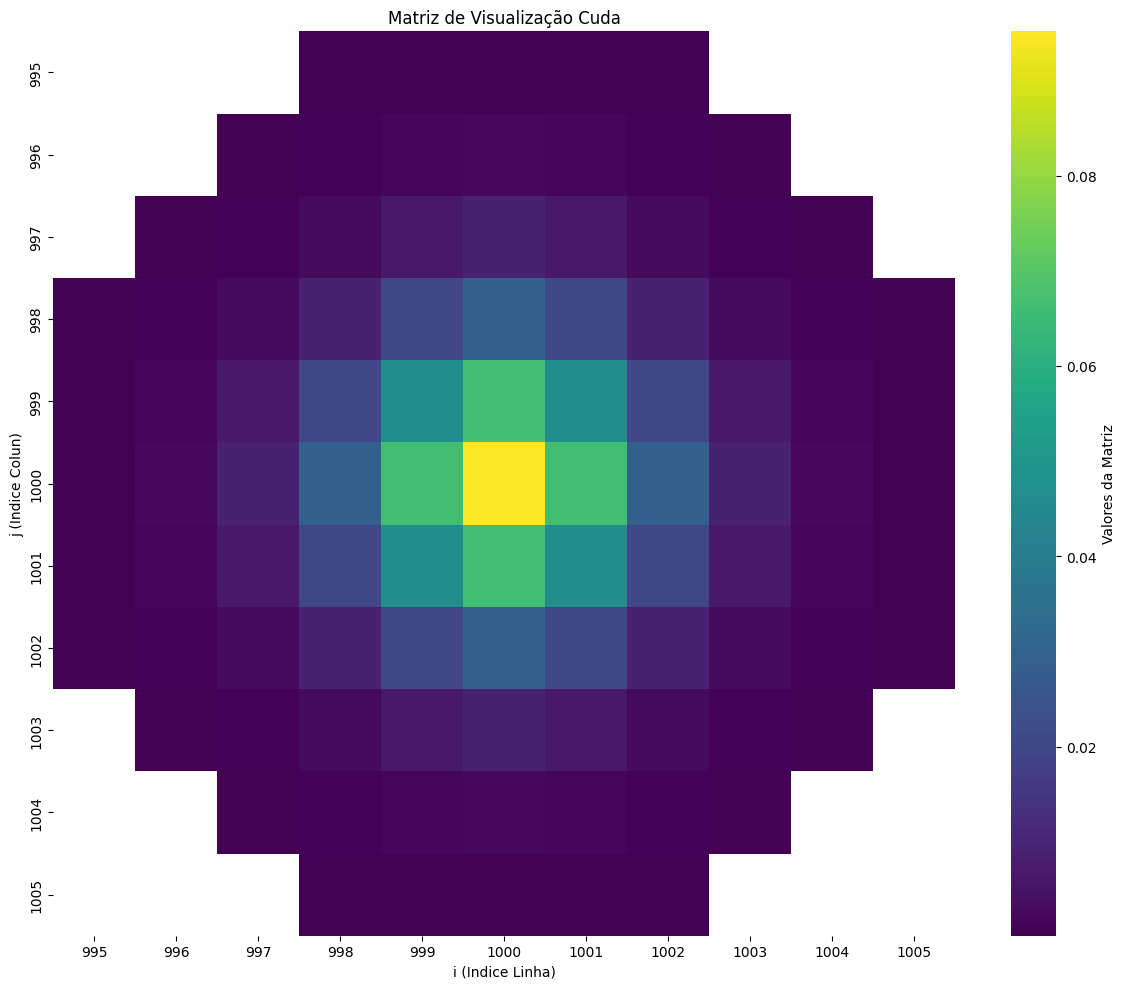

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lê o arquivo csv e pega os dados da matriz
df = pd.read_csv('/content/matriz_Cuda_output.csv')

# Cria matriz de visualização
pivot_matrix = df.pivot(index='i', columns='j', values='Matriz')
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_matrix, cmap='viridis', cbar_kws={'label': 'Valores da Matriz'})

plt.title('Matriz de Visualização Cuda')
plt.ylabel('j (Indice Colun)')
plt.xlabel('i (Indice Linha)')
plt.tight_layout()

# Salva
#plt.savefig('/content/matriz_Cuda_output.png')

# Plota
plt.show()

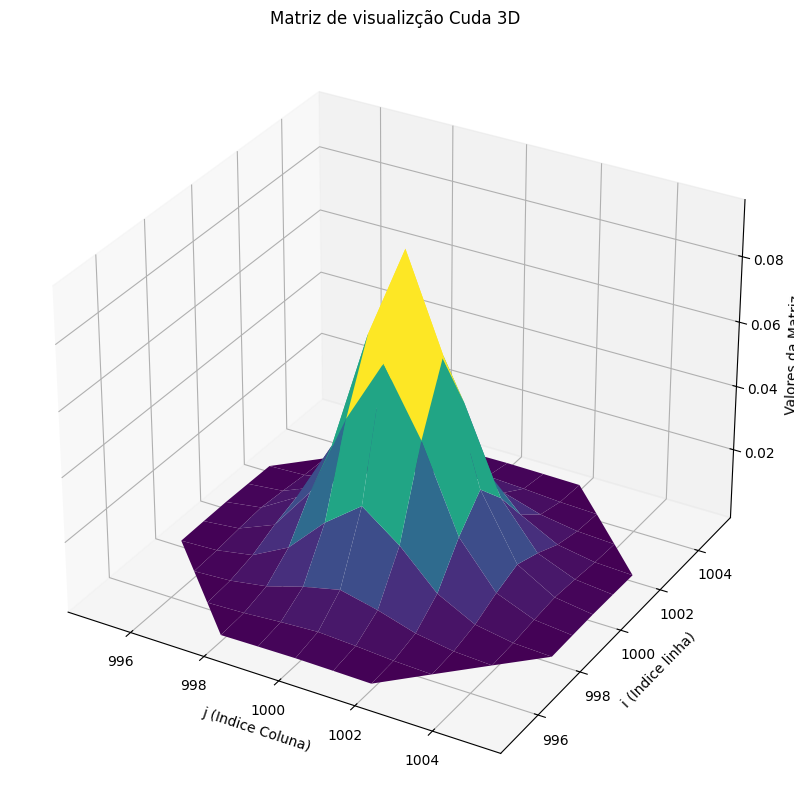

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(pivot_matrix.columns, pivot_matrix.index)
ax.plot_surface(X, Y, pivot_matrix.values, cmap='viridis')

ax.set_title('Matriz de visualizção Cuda 3D')
ax.set_xlabel('j (Indice Coluna)')
ax.set_ylabel('i (Indice linha)')
ax.set_zlabel('Valores da Matriz')
plt.show()

## Código de modelo de difusão **Sequencial**



In [ ]:
# Cria o arquivo que salvar a matriz
open('/content/matriz_sequencial_output.txt', 'w').close()

In [ ]:
%%writefile difusaoSequencial.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

#define N 2000  // Tamanho da grade
#define T 1000  // Quantidade de iterações
#define D 0.1   // Coeficiente de coesão
#define DELTA_T 0.01
#define DELTA_X 1.0

void diff_eq(double **C, double **C_new) {
    for (int t = 0; t < T; t++) {
        // Calculo da equação de difusão para toda a matrix
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                C_new[i][j] = C[i][j] + D * DELTA_T * (
                    (C[i+1][j] + C[i-1][j] + C[i][j+1] + C[i][j-1] - 4 * C[i][j]) / (DELTA_X * DELTA_X)
                );
            }
        }

        // Atualiza a matriz para a próxima iteração
        double difmedio = 0.;
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                difmedio += fabs(C_new[i][j] - C[i][j]);    // fabs = pega o valor absoluto
                C[i][j] = C_new[i][j];
            }
        }
        if ((t % 100) == 0)
            printf("Iteração %d - diferença média=%g\n", t, difmedio / ((N - 2) * (N - 2)));
    }
}

int main() {
    // ------- Concentração Inicial -------
    // Cria a matriz C de tamanho N
    double **C = (double **)malloc(N * sizeof(double *));
    if (C == NULL) {
        fprintf(stderr, "Falha na alocação de memória\n");
        return 1;
    }

    for (int i = 0; i < N; i++) {
        C[i] = (double *)malloc(N * sizeof(double));
        if (C[i] == NULL) {
            fprintf(stderr, "Falha na alocação de memória\n");
            return 1;
        }
    }

    // Inicializa a matriz C
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            C[i][j] = 0.0;
        }
    }

    double **C_new = (double **)malloc(N * sizeof(double *));
    if (C_new == NULL) {
        fprintf(stderr, "Falha na alocação de memória\n");
        return 1;
    }

    for (int i = 0; i < N; i++) {
        C_new[i] = (double *)malloc(N * sizeof(double));
        if (C_new[i] == NULL) {
            fprintf(stderr, "Falha na alocação de memória\n");
            return 1;
        }
    }

    // Inicializa a matriz C_new
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            C_new[i][j] = 0.0;
        }
    }

    // Inicializa a concentração no centro
    C[N / 2][N / 2] = 1.0;

    // Executa o processo da equação de difusão
    diff_eq(C, C_new);

    // Exibe os resultados
    printf("\nConcentração final no centro: %f\n", C[N / 2][N / 2]);

    // Salvando matrix no aqruivo txt
    FILE *fp = fopen("/content/matriz_sequencial_output.txt", "w");

    if(fp == NULL) {
      printf("Erro ao abrir arquivo.txt");
    }
    else {
      for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
          if(C[i][j] >= 0.0001)
            fprintf(fp, "i:%d j:%d Matriz:%f ", i, j, C[i][j]);
        }
        fprintf(fp, "\n");
      }
      fclose(fp);
    }

    // Libera memória alocada
    for (int i = 0; i < N; i++) {
        free(C[i]);
        free(C_new[i]);
    }
    free(C);
    free(C_new);

    return 0;
}

Writing difusaoSequencial.c


In [ ]:
!rm difusaoSequencial.x
!gcc difusaoSequencial.c -o difusaoSequencial.x
!time ./difusaoSequencial.x

rm: cannot remove 'difusaoSequencial.x': No such file or directory
Iteração 0 - diferença média=2.00401e-09
Iteração 100 - diferença média=1.23248e-09
Iteração 200 - diferença média=7.81794e-10
Iteração 300 - diferença média=5.11528e-10
Iteração 400 - diferença média=4.21632e-10
Iteração 500 - diferença média=3.62223e-10
Iteração 600 - diferença média=3.05976e-10
Iteração 700 - diferença média=2.57135e-10
Iteração 800 - diferença média=2.21174e-10
Iteração 900 - diferença média=2.00244e-10

Concentração final no centro: 0.095045

real	1m12.637s
user	1m11.946s
sys	0m0.081s


### Checando se resultados de Matriz se coincidem com openMP

In [ ]:
import pandas as pd
import numpy as np
import re

# Le arquivo txt e pega os dados da matriz
with open('/content/matriz_sequencial_output.txt', 'r') as file:
    content = file.read()

matches = re.findall(r'i:(\d+) j:(\d+) Matriz:(\d+\.\d+)', content)

if matches:
    # Transforma dados em lista
    data = [[int(i), int(j), f'{float(Matriz):.6e}'] for i, j, Matriz in matches]

    # Cria no formato DataFrame para se inserido na planilha
    df = pd.DataFrame(data, columns=['i', 'j', 'Matriz'])

    df.to_csv('/content/matriz_sequencial_output.csv', index=False)

    print(df.head())

    # Mostrar resultados
    with open('/content/matriz_sequencial_output.csv', 'r') as f:
        print("Valoress da planilha:")
        print(f.read())
else:
    print("Erro em ler os dados do txt.")

     i     j        Matriz
0  995   998  1.230000e-04
1  995   999  2.860000e-04
2  995  1000  4.100000e-04
3  995  1001  2.860000e-04
4  995  1002  1.230000e-04
Valoress da planilha:
i,j,Matriz
995,998,1.230000e-04
995,999,2.860000e-04
995,1000,4.100000e-04
995,1001,2.860000e-04
995,1002,1.230000e-04
996,997,1.970000e-04
996,998,6.390000e-04
996,999,1.477000e-03
996,1000,2.118000e-03
996,1001,1.477000e-03
996,1002,6.390000e-04
996,1003,1.970000e-04
997,996,1.970000e-04
997,997,8.270000e-04
997,998,2.684000e-03
997,999,6.201000e-03
997,1000,8.887000e-03
997,1001,6.201000e-03
997,1002,2.684000e-03
997,1003,8.270000e-04
997,1004,1.970000e-04
998,995,1.230000e-04
998,996,6.390000e-04
998,997,2.684000e-03
998,998,8.700000e-03
998,999,2.008700e-02
998,1000,2.877700e-02
998,1001,2.008700e-02
998,1002,8.700000e-03
998,1003,2.684000e-03
998,1004,6.390000e-04
998,1005,1.230000e-04
999,995,2.860000e-04
999,996,1.477000e-03
999,997,6.201000e-03
999,998,2.008700e-02
999,999,4.635500e-02
999,1000,6

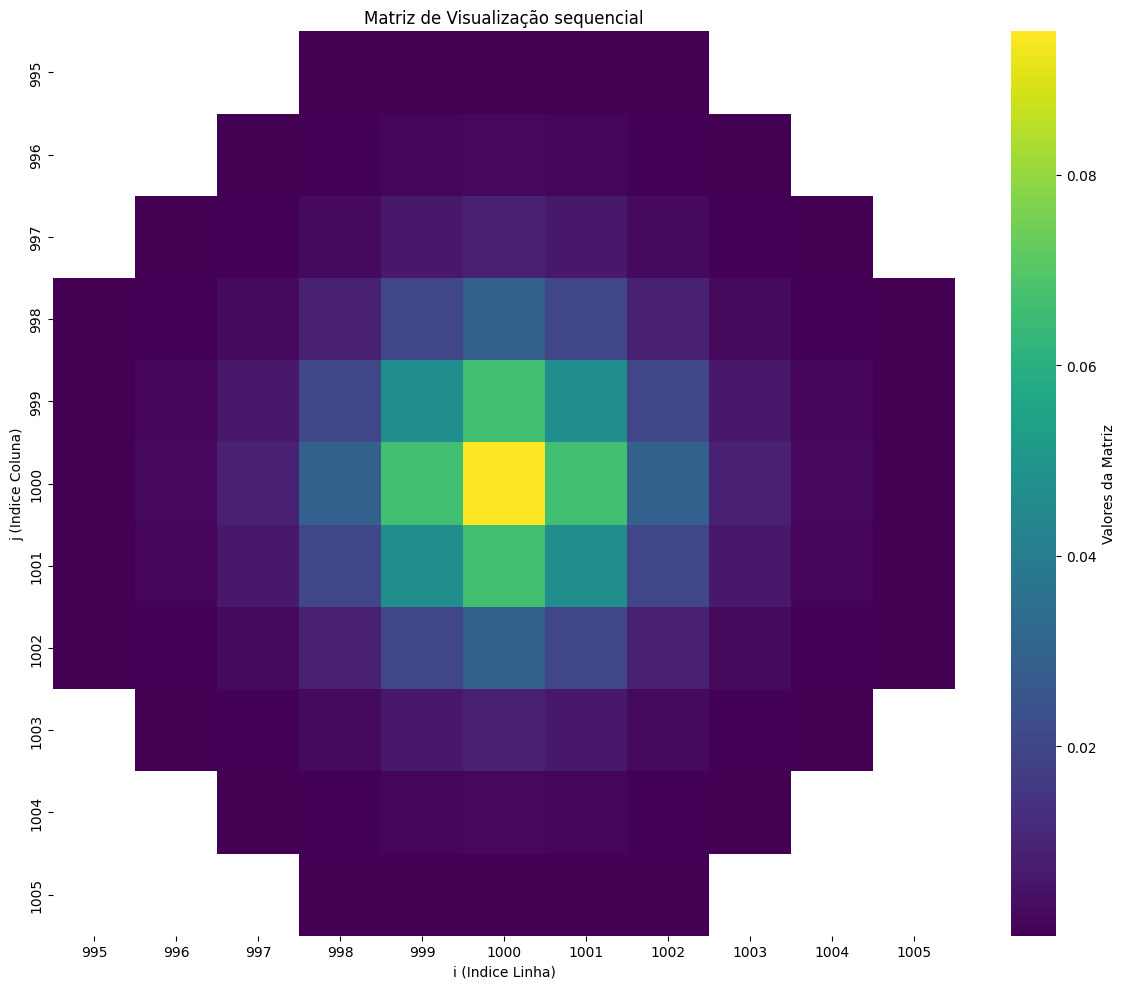

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Le arquivo csv e pega os dados
df = pd.read_csv('/content/matriz_sequencial_output.csv')

# Cria matriz de visualização
pivot_matrix = df.pivot(index='i', columns='j', values='Matriz')
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_matrix, cmap='viridis', cbar_kws={'label': 'Valores da Matriz'})

plt.title('Matriz de Visualização sequencial')
plt.ylabel('j (Indice Coluna)')
plt.xlabel('i (Indice Linha)')
plt.tight_layout()

# Salva
plt.savefig('/content/matriz_sequencial_output.png')

# Plota
plt.show()

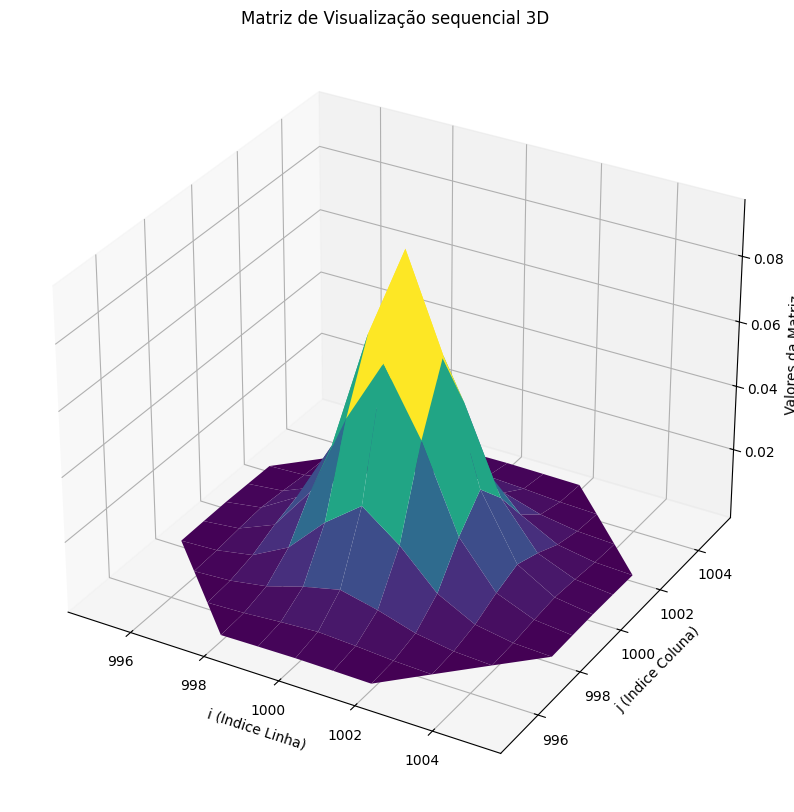

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Cria matrix de visulização 3d
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(pivot_matrix.columns, pivot_matrix.index)
ax.plot_surface(X, Y, pivot_matrix.values, cmap='viridis')

ax.set_title('Matriz de Visualização sequencial 3D')
ax.set_ylabel('j (Indice Coluna)')
ax.set_xlabel('i (Indice Linha)')
ax.set_zlabel('Valores da Matriz')
plt.show()

## Código de modelo de difusão usando **OpenMP**

In [ ]:
# Cria o arquivo que salvar a matriz
open('/content/matriz_openMP_output.txt', 'w').close()

In [ ]:
%%writefile difusaoOpenMP.c


#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

#define N 2000  // Tamanho da grade
#define T 1000  // Quantidade de iterações
#define D 0.1   // Coeficiente de coesão
#define DELTA_T 0.01
#define DELTA_X 1.0

void diff_eq(double **C, double **C_new) {
    int i, j;

    for (int t = 0; t < T; t++) {
        // Paralelização da equação de difusão
        #pragma omp parallel for collapse(2) shared(C_new, C) private(i, j)
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                C_new[i][j] = C[i][j] + D * DELTA_T * (
                    (C[i+1][j] + C[i-1][j] + C[i][j+1] + C[i][j-1] - 4 * C[i][j]) / (DELTA_X * DELTA_X)
                );
            }
        }

        // Atualiza a matriz para a próxima iteração
        double difmedio = 0.;

        // Paralelização da diferença média
        #pragma omp parallel for collapse(2) shared(C_new, C) private(i, j) reduction(+:difmedio)
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                difmedio += fabs(C_new[i][j] - C[i][j]);    // fabs = pega o valor absoluto
                C[i][j] = C_new[i][j];
            }
        }

        // // Checar a quantidade de threads rodando
        // if (t == 0) {
        //     #pragma omp parallel
        //     {
        //         if (omp_get_thread_num() == 0) {
        //             printf("Número total de threads sendo usadas: %d\n", omp_get_num_threads());
        //         }
        //     }
        // }

        if ((t % 100) == 0)
          printf("Iteração %d - diferença média=%g\n", t, difmedio / ((N - 2) * (N - 2)));
    }
}

int main() {
    double start_time, elapsed_time;

    // Inicializa o tempo do código
    start_time = omp_get_wtime();

    int i, j;

    // int numb_threads = 2;
    // int numb_threads = 3;
    int numb_threads = 4;
    // int numb_threads = 6;
    // int numb_threads = 8;

    // Configuração do número de threads do OpenMP
    omp_set_num_threads(numb_threads);

    // ------- Concentração Inicial -------
    // Cria a matriz C de tamanho N
    double **C = (double **)malloc(N * sizeof(double *));

    // Verifica se a matriz foi criada corretamente
    if (C == NULL) {
      fprintf(stderr, "Falha na alocação de memória\n");
      return 1;
    }

    // Cria o restante da matriz C de tamanho N*N
    for (int i = 0; i < N; i++) {
      C[i] = (double *)malloc(N * sizeof(double));
      if (C[i] == NULL) {
        fprintf(stderr, "Falha na alocação de memória\n");
        return 1;
      }
    }

    // Limpa a matriz C
    #pragma omp parallel for collapse(2)
    for (int i = 0; i < N; i++) {
      for (int j = 0; j < N; j++) {
        C[i][j] = 0.;
      }
    }

    // ------- Concentração para a próxima iteração -------
    // Cria a matriz C_new de tamanho N
    double **C_new = (double **)malloc(N * sizeof(double *));

    // Verifica se a matriz foi criada corretamente
    if (C_new == NULL) {
      fprintf(stderr, "Falha na alocação de memória\n");
      return 1;
    }

    // Cria o restante da matriz C_new de tamanho N*N
    for (int i = 0; i < N; i++) {
      C_new[i] = (double *)malloc(N * sizeof(double));
      if (C_new[i] == NULL) {
        fprintf(stderr, "Falha na alocação de memória\n");
        return 1;
      }
    }

    // Limpa a matriz C_new
    #pragma omp parallel for collapse(2) shared(C_new) private(i, j)
    for (int i = 0; i < N; i++) {
      for (int j = 0; j < N; j++) {
        C_new[i][j] = 0.;
      }
    }

    // Inicializa a concentração no centro da matriz C
    C[N / 2][N / 2] = 1.0;

    // Executa o processo da equação de difusão com as matrizes
    diff_eq(C, C_new);

    // Finaliza o tempo do processo da equação
    elapsed_time = (omp_get_wtime() - start_time);

    // Exibe os resultados
    printf("\nConcentração final no centro: %f\n", C[N / 2][N / 2]);

   // Salva a matrix no arquivo de planilha
   FILE *fp = fopen("/content/openMP.txt", "w");

    // Salvando matrix no aqruivo txt
    if(fp == NULL) {
      printf("Erro ao abrir arquivo .txt\n");
    }
    else {
      for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
          if(C[i][j] >= 0.0001)
            fprintf(fp, "i:%d j:%d Matriz:%f ", i, j, C[i][j]);
        }
        fprintf(fp, "\n");
      }
      fclose(fp);
    }

    // Liberar memória alocada
    for (int i = 0; i < N; i++) {
        free(C[i]);
        free(C_new[i]);
    }
    free(C);
    free(C_new);


    printf("Tempo final do código: %f\n", elapsed_time);

    return 0;
}

Writing difusaoOpenMP.c


In [ ]:
!rm difusaoOpenMP.x
!gcc -fopenmp difusaoOpenMP.c -o difusaoOpenMP.x
!time ./difusaoOpenMP.x

rm: cannot remove 'difusaoOpenMP.x': No such file or directory
Iteração 0 - diferença média=2.00401e-09
Iteração 100 - diferença média=1.23248e-09
Iteração 200 - diferença média=7.81794e-10
Iteração 300 - diferença média=5.11528e-10
Iteração 400 - diferença média=4.21632e-10
Iteração 500 - diferença média=3.62223e-10
Iteração 600 - diferença média=3.05976e-10
Iteração 700 - diferença média=2.57135e-10
Iteração 800 - diferença média=2.21174e-10
Iteração 900 - diferença média=2.00244e-10

Concentração final no centro: 0.095045
Tempo final do código: 60.999724

real	1m1.017s
user	1m44.343s
sys	0m0.260s


### Checando se resultados de Matriz se coincidem com sequencial

In [ ]:
import pandas as pd
import numpy as np
import re

# Le arquivo txt e pega os dados
with open('/content/matriz_openMP_output.txt', 'r') as file:
    content = file.read()

matches = re.findall(r'i:(\d+) j:(\d+) Matriz:(\d+\.\d+)', content)

if matches:
    # Transforma dados em lista
    data = [[int(i), int(j), f'{float(Matriz):.6e}'] for i, j, Matriz in matches]

    # Cria no formato DataFrame para se inserido na planilha
    df = pd.DataFrame(data, columns=['i', 'j', 'Matriz'])

    df.to_csv('/content/matriz_openMP_output.csv', index=False)

    print(df.head())

    # Mostrar ressultados
    with open('/content/matriz_openMP_output.csv', 'r') as f:
        print("Valoress da planilha:")
        print(f.read())
else:
    print("Erro em ler os dados do txt.")

Erro em ler os dados do txt.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lê o arquivo csv e pega os dados da matriz
df = pd.read_csv('/content/matriz_openMP_output.csv')

# Cria matriz de visualização
pivot_matrix = df.pivot(index='i', columns='j', values='Matriz')
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_matrix, cmap='viridis', cbar_kws={'label': 'Valores da Matriz'})

plt.title('Matriz de Visualização openMP')
plt.ylabel('j (Indice Colun)')
plt.xlabel('i (Indice Linha)')
plt.tight_layout()

# Salva
#plt.savefig('/content/matriz_openMP_output.png')

# Plota
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/matriz_openMP_output.csv'

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(pivot_matrix.columns, pivot_matrix.index)
ax.plot_surface(X, Y, pivot_matrix.values, cmap='viridis')

ax.set_title('Matriz de visualizção openMP 3D')
ax.set_xlabel('j (Indice Coluna)')
ax.set_ylabel('i (Indice linha)')
ax.set_zlabel('Valores da Matriz')
plt.show()

In [ ]:
!more /proc &> processador.txt
!more processador.txt | grep model